In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform, cosine

In [3]:
# Function to parse the text file
def parse_file(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')  # To handle division by zero
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

# Function to load chromosome 1 matrix
def load_chr1_matrix(data, chr1_size):
    # Filter for chr1 interactions
    chr1_data = data[(data['chr1'] == 'chr1') & (data['chr2'] == 'chr1')]
    
    # Initialize matrix for chr1
    chr1_matrix = np.zeros((chr1_size, chr1_size))
    
    # Populate the matrix with interaction data
    for _, row in chr1_data.iterrows():
        pos1 = row['pos1'] // 1000000
        pos2 = row['pos2'] // 1000000
        interaction = row['interaction']
        
        if pos1 < chr1_size and pos2 < chr1_size:
            chr1_matrix[pos1, pos2] += interaction
            chr1_matrix[pos2, pos1] += interaction  # Ensure symmetry
    
    return chr1_matrix

# Function to load matrices from a directory
def load_chr1_matrices(directory, chr1_size):
    chr1_matrices = []
    filepaths = []
    
    for filename in tqdm(os.listdir(directory), desc="Processing files"):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            data = parse_file(filepath)
            if data is not None:
                chr1_matrix = load_chr1_matrix(data, chr1_size)
                chr1_matrices.append(chr1_matrix)
                filepaths.append(filepath)
            else:
                print(f"Data is None for file {filepath}, skipping.")
    
    return chr1_matrices, filepaths

In [4]:
# Define the directories and max_bin
directories = {
    'GM12878': './GM12878',
    'HAP1': './HAP1',
    'Hela': './Hela',
    'K562': './K562'
}

max_bin = {
    'chr1': 230  # Only need chr1 size for this task
}

In [5]:
# Compute matrices for each cell type separately and concatenate
GM12878_cells, _ = load_chr1_matrices(directories['GM12878'], max_bin['chr1'])
HAP1_cells, _ = load_chr1_matrices(directories['HAP1'], max_bin['chr1'])
Hela_cells, _ = load_chr1_matrices(directories['Hela'], max_bin['chr1'])
K562_cells, _ = load_chr1_matrices(directories['K562'], max_bin['chr1'])

# Combine all cells from all types into one list
all_chr1_matrices = GM12878_cells + HAP1_cells + Hela_cells + K562_cells

Processing files: 100%|██████████| 48/48 [00:00<00:00, 112.02it/s]


In [10]:
# Function to flatten and concatenate matrices of different shapes
def flatten_and_concatenate_matrices(matrices):
    flattened_vectors = [matrix.flatten() for matrix in matrices]
    concatenated_vector = np.concatenate(flattened_vectors)
    return concatenated_vector
# Function to prepare data for UMAP
def prepare_data_for_umap(cells):
    concatenated_vectors = [flatten_and_concatenate_matrices(cell) for cell in cells]
    return np.array(concatenated_vectors)

In [11]:
# Prepare data for UMAP
GM12878_vectors = prepare_data_for_umap(GM12878_cells)
HAP1_vectors = prepare_data_for_umap(HAP1_cells)
Hela_vectors = prepare_data_for_umap(Hela_cells)
K562_vectors = prepare_data_for_umap(K562_cells)

In [12]:
# Combine all data for UMAP
all_vectors = np.vstack([GM12878_vectors, HAP1_vectors, Hela_vectors, K562_vectors])
labels = (
    [1] * len(GM12878_vectors) +
    [2] * len(HAP1_vectors) +
    [3] * len(Hela_vectors) +
    [4] * len(K562_vectors)
)
labels = np.array(labels)

In [13]:
from umap import UMAP
# Configure UMAP hyperparameters
reducer = UMAP(n_neighbors=5, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0, # default 0.1, The effective minimum distance between embedded points.
               random_state=10
              )
transformed_data = reducer.fit_transform(all_vectors)

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [17]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat = np.concatenate((X, y.reshape(y.shape[0], 1)), axis=1)
    # Create a Pandas dataframe using the above array
    df = pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                      margin=dict(l=0, r=0, b=0, t=0),
                      scene=dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 zaxis=dict(backgroundcolor='lightgrey',
                                            color='black', 
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10))))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    
    fig.show()

In [19]:
import plotly.express as px
chart(transformed_data, labels)

Cluster labels for each cell: [1 1 1 ... 1 1 1]


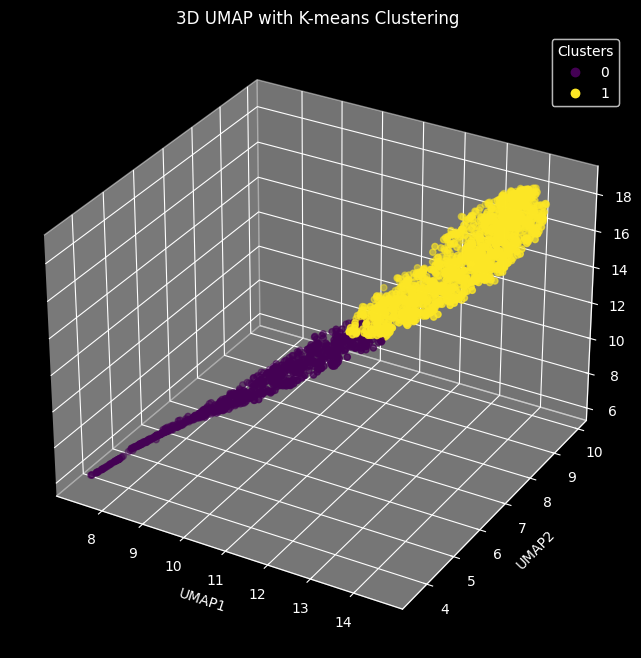

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply K-means clustering with k=4
kmeans = KMeans(n_clusters=2, random_state=42, algorithm="lloyd")
kmeans.fit(transformed_data)
labels = kmeans.labels_

# Print the resulting labels
print("Cluster labels for each cell:", labels)

# Create a 3D scatter plot to visualize the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with cluster labels as colors
scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=labels, cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('3D UMAP with K-means Clustering')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()